In [1]:
# Imports
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.nn.functional as F
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import os
import cv2
import pandas as pd
from skimage import io
from torch.optim.lr_scheduler import StepLR

# import scripts
from scripts.saveResults import  *
from torch.utils.data import (
    Dataset,
    DataLoader,
)  # Gives easier dataset managment and creates mini batches

Dataset 

In [2]:

class SolarRadiance(Dataset):
    def __init__(self, root_dir, labels, transform):
        self.root_dir = root_dir
        self.labels = labels
        self.transform = transform
        # self.data = self.load_dataset()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img_path = self.labels.iloc[index,0]
        target = self.labels.iloc[index,1]

        image = io.imread(img_path)
        image = cv2.imread(img_path)#, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (60, 80))

        if self.transform:
             image = self.transform(image)

        y_label = torch.tensor(target)

        return image, y_label

In [3]:
def load_dataset(root_dir):
        ds = pd.DataFrame()
        dates = os.listdir(root_dir)

        try:
            for date in dates:
                infrared_folder = os.path.join(root_dir, date, "infrared")
                pyranometer_folder = os.path.join(root_dir, date, "pyranometer")
                csv_path = os.path.join(pyranometer_folder, "{date}.csv".format(date=date))
                if not os.path.exists(csv_path):
                    print("Skipping date {date} because it does not have both infrared and pyranometer folders".format(date=date))
                    continue
                ds_temp = getDs(infrared_folder, csv_path)
                
                # append the dataframe in the final dataframe
                # ds = ds.append(ds_temp)
                ds = pd.concat([ds, ds_temp], ignore_index=True)

                ds['name'] = ds['name'].apply(lambda img: os.path.join(root_dir, date, 'infrared', img))
        except Exception as e:
            print(e)
        return ds

def getDs(path, labels):
    pyranometer = pd.read_csv(labels)
    images = os.listdir(path)
    
   
    #convert column 1 to int
    X = pyranometer.iloc[:,0].astype(int)

    #convert to image names
    pyranometer.iloc[:,0] = X.apply(lambda x: str(x) + 'IR.png')
    
    # Filter pyranometer DataFrame based on the 'x' column

    filtered_pyranometer = pyranometer[pyranometer.iloc[:,0].isin(images)]
    # Display the result
    filtered_pyranometer.columns = ['name', 'value']

    filtered_pyranometer = filtered_pyranometer.drop_duplicates(subset='name')
    return filtered_pyranometer

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load Data

In [5]:

# Hyperparameters
in_channel = 1
batch_size = 50
num_epochs = 50
loss = 1 # if loss = 0 the model will be trained with RMSE loss and vice versa
lr=0.01 # learning rate

In [8]:
result_dir = 'result/student/'

In [9]:
root = 'F:/Girasol/extracted/train/'
data  = load_dataset(root)
random_seed = 42
dataset = SolarRadiance(root_dir= root, labels=data, transform = transforms.Compose([transforms.ToTensor()]))

torch.manual_seed(random_seed)
datasetLength = len(dataset)
print(datasetLength)
train_size = int(0.8 * datasetLength)
val_size = datasetLength - train_size

train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)

46527


Model

In [10]:
import torch
import torch.nn as nn

img_x = 60
img_y = 80

class CNNRegression(nn.Module):
    def __init__(self, image_size, num_channels):
        super(CNNRegression, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(int(img_x/4) * int(img_y/4) * 32, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x
model = CNNRegression(60, 3).to(device)
model.to(device)
model.train()

CNNRegression(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9600, out_features=64, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

Loss and Optimizers

In [11]:
if loss == 0:
    # create a function (this my favorite choice)
    def RMSELoss(yhat,y):
        return torch.sqrt(torch.mean((yhat-y)**2))
    criterion = RMSELoss
else:
    # Define the model, loss function, and optimizer
    criterion = nn.MSELoss()
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Create a StepLR scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

# set initial loswest_loss to an infinite number
lowest_loss = 10000000


In [12]:
losses = []

from tqdm import tqdm
# Train the model
for epoch in range(num_epochs):
    scheduler.step()
    print('Epoch ',epoch)
    for i, (inputs, targets) in enumerate(tqdm(train_loader)):
        # Zero the gradients
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs[:,0], targets.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Evaluate the model on the test data
    with torch.no_grad():
        total_loss = 0
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs[:,0], targets.float())
            total_loss += loss.item()
        mean_loss = total_loss / len(val_loader)
        print(f'val Loss: {mean_loss:.4f}')
        losses.append(mean_loss)
        if  mean_loss<lowest_loss:
            print('mean_loss '+str(mean_loss)+'lowest_loss'+str(lowest_loss))
            print('RMSE LOSS: '+str(torch.sqrt(torch.tensor(mean_loss))))
            lowest_loss = mean_loss
            torch.save(model.state_dict(), os.path.join(result_dir,'student.pth'))

c:\Users\nijhu\anaconda3\envs\pytorch\Lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch  0


100%|██████████| 745/745 [05:21<00:00,  2.32it/s]


val Loss: 12128.0785
mean_loss 12128.078469669117lowest_loss10000000
RMSE LOSS: tensor(110.1276)
Epoch  1


100%|██████████| 745/745 [04:27<00:00,  2.78it/s]


val Loss: 6438.5688
mean_loss 6438.568829378342lowest_loss12128.078469669117
RMSE LOSS: tensor(80.2407)
Epoch  2


100%|██████████| 745/745 [04:09<00:00,  2.99it/s]


val Loss: 3876.2351
mean_loss 3876.2351485471672lowest_loss6438.568829378342
RMSE LOSS: tensor(62.2594)
Epoch  3


100%|██████████| 745/745 [01:40<00:00,  7.42it/s]


val Loss: 3615.2507
mean_loss 3615.2507317690925lowest_loss3876.2351485471672
RMSE LOSS: tensor(60.1270)
Epoch  4


100%|██████████| 745/745 [01:28<00:00,  8.42it/s]


val Loss: 3377.9714
mean_loss 3377.971430977398lowest_loss3615.2507317690925
RMSE LOSS: tensor(58.1203)
Epoch  5


100%|██████████| 745/745 [01:26<00:00,  8.65it/s]


val Loss: 3248.8784
mean_loss 3248.8783814129347lowest_loss3377.971430977398
RMSE LOSS: tensor(56.9989)
Epoch  6


100%|██████████| 745/745 [01:24<00:00,  8.86it/s]


val Loss: 3154.4086
mean_loss 3154.408590224975lowest_loss3248.8783814129347
RMSE LOSS: tensor(56.1641)
Epoch  7


100%|██████████| 745/745 [01:23<00:00,  8.94it/s]


val Loss: 3096.5582
mean_loss 3096.558166177515lowest_loss3154.408590224975
RMSE LOSS: tensor(55.6467)
Epoch  8


100%|██████████| 745/745 [01:22<00:00,  9.01it/s]


val Loss: 3084.2300
mean_loss 3084.230024205172lowest_loss3096.558166177515
RMSE LOSS: tensor(55.5358)
Epoch  9


100%|██████████| 745/745 [01:22<00:00,  9.04it/s]


val Loss: 3037.5530
mean_loss 3037.5529745989306lowest_loss3084.230024205172
RMSE LOSS: tensor(55.1140)
Epoch  10


100%|██████████| 745/745 [03:25<00:00,  3.62it/s]


val Loss: 3032.6229
mean_loss 3032.6229274158172lowest_loss3037.5529745989306
RMSE LOSS: tensor(55.0693)
Epoch  11


100%|██████████| 745/745 [01:46<00:00,  7.02it/s]


val Loss: 3024.3651
mean_loss 3024.3650963115183lowest_loss3032.6229274158172
RMSE LOSS: tensor(54.9942)
Epoch  12


100%|██████████| 745/745 [01:22<00:00,  9.02it/s]


val Loss: 3017.2394
mean_loss 3017.239350507604lowest_loss3024.3650963115183
RMSE LOSS: tensor(54.9294)
Epoch  13


100%|██████████| 745/745 [01:21<00:00,  9.14it/s]


val Loss: 3021.7219
Epoch  14


100%|██████████| 745/745 [01:22<00:00,  9.01it/s]


val Loss: 3027.4680
Epoch  15


100%|██████████| 745/745 [01:22<00:00,  9.04it/s]


val Loss: 3023.9400
Epoch  16


100%|██████████| 745/745 [01:21<00:00,  9.15it/s]


val Loss: 3020.6615
Epoch  17


100%|██████████| 745/745 [01:21<00:00,  9.11it/s]


val Loss: 3033.6475
Epoch  18


100%|██████████| 745/745 [01:22<00:00,  9.00it/s]


val Loss: 3038.6872
Epoch  19


100%|██████████| 745/745 [01:25<00:00,  8.74it/s]


val Loss: 3026.3182
Epoch  20


100%|██████████| 745/745 [01:21<00:00,  9.13it/s]


val Loss: 3018.6075
Epoch  21


100%|██████████| 745/745 [01:24<00:00,  8.79it/s]


val Loss: 3025.5366
Epoch  22


100%|██████████| 745/745 [01:21<00:00,  9.10it/s]


val Loss: 3019.9097
Epoch  23


100%|██████████| 745/745 [01:23<00:00,  8.91it/s]


val Loss: 3019.8437
Epoch  24


100%|██████████| 745/745 [01:23<00:00,  8.88it/s]


val Loss: 3018.9880
Epoch  25


100%|██████████| 745/745 [01:22<00:00,  9.03it/s]


val Loss: 3044.5560
Epoch  26


100%|██████████| 745/745 [01:22<00:00,  9.04it/s]


val Loss: 3026.8596
Epoch  27


100%|██████████| 745/745 [01:22<00:00,  9.08it/s]


val Loss: 3020.8527
Epoch  28


100%|██████████| 745/745 [01:22<00:00,  8.99it/s]


val Loss: 3044.5069
Epoch  29


100%|██████████| 745/745 [01:33<00:00,  7.98it/s]


val Loss: 3015.6341
mean_loss 3015.634140912224lowest_loss3017.239350507604
RMSE LOSS: tensor(54.9148)
Epoch  30


100%|██████████| 745/745 [33:28<00:00,  2.70s/it]    


val Loss: 3029.0315
Epoch  31


100%|██████████| 745/745 [02:26<00:00,  5.09it/s]


val Loss: 3021.5077
Epoch  32


100%|██████████| 745/745 [01:25<00:00,  8.74it/s]


val Loss: 3023.1547
Epoch  33


100%|██████████| 745/745 [01:28<00:00,  8.47it/s]


val Loss: 3031.3242
Epoch  34


100%|██████████| 745/745 [01:44<00:00,  7.15it/s]


val Loss: 3032.5905
Epoch  35


100%|██████████| 745/745 [02:01<00:00,  6.14it/s]


val Loss: 3015.6698
Epoch  36


100%|██████████| 745/745 [01:38<00:00,  7.55it/s]


val Loss: 3017.9718
Epoch  37


100%|██████████| 745/745 [01:32<00:00,  8.09it/s]


val Loss: 3031.3574
Epoch  38


100%|██████████| 745/745 [01:25<00:00,  8.73it/s]


val Loss: 3023.9648
Epoch  39


100%|██████████| 745/745 [01:31<00:00,  8.12it/s]


val Loss: 3017.7206
Epoch  40


100%|██████████| 745/745 [01:35<00:00,  7.84it/s]


val Loss: 3036.1436
Epoch  41


100%|██████████| 745/745 [01:23<00:00,  8.96it/s]


val Loss: 3034.4226
Epoch  42


100%|██████████| 745/745 [01:20<00:00,  9.27it/s]


val Loss: 3018.3746
Epoch  43


100%|██████████| 745/745 [01:17<00:00,  9.64it/s]


val Loss: 3054.0935
Epoch  44


100%|██████████| 745/745 [01:18<00:00,  9.51it/s]


val Loss: 3027.8612
Epoch  45


100%|██████████| 745/745 [01:18<00:00,  9.55it/s]


val Loss: 3030.7727
Epoch  46


100%|██████████| 745/745 [01:17<00:00,  9.61it/s]


val Loss: 3070.9182
Epoch  47


100%|██████████| 745/745 [01:18<00:00,  9.53it/s]


val Loss: 3053.8526
Epoch  48


100%|██████████| 745/745 [01:17<00:00,  9.66it/s]


val Loss: 3017.4985
Epoch  49


100%|██████████| 745/745 [01:15<00:00,  9.88it/s]


val Loss: 3026.5922


Results

In [13]:
# save the losses per epoch
import pickle

# Save the list to a file
with open(result_dir+'/losses.pkl', 'wb') as file:
    pickle.dump(losses, file)

In [14]:
# Load the list from the file
losses_path = os.path.join(result_dir,'losses.pkl')
with open(losses_path, 'rb') as file:
    losses = pickle.load(file)
print(losses)

[12128.078469669117, 6438.568829378342, 3876.2351485471672, 3615.2507317690925, 3377.971430977398, 3248.8783814129347, 3154.408590224975, 3096.558166177515, 3084.230024205172, 3037.5529745989306, 3032.6229274158172, 3024.3650963115183, 3017.239350507604, 3021.721885313962, 3027.467987550134, 3023.9400203929226, 3020.661450064756, 3033.647494882186, 3038.6872193035597, 3026.318207929479, 3018.6074956394136, 3025.5366113020136, 3019.90966796875, 3019.843740861046, 3018.987974442263, 3044.555957814589, 3026.859597598805, 3020.8526732092873, 3044.5068522570605, 3015.634140912224, 3029.031522210269, 3021.507658443349, 3023.154679405498, 3031.3242004720923, 3032.590461282169, 3015.6698308118525, 3017.9717815215577, 3031.357411430481, 3023.964792180189, 3017.720627402239, 3036.1436186601773, 3034.4225565048464, 3018.37463052515, 3054.0935117344166, 3027.8612386938084, 3030.7726698278743, 3070.918242918616, 3053.8526069518716, 3017.498480975309, 3026.59216634985]


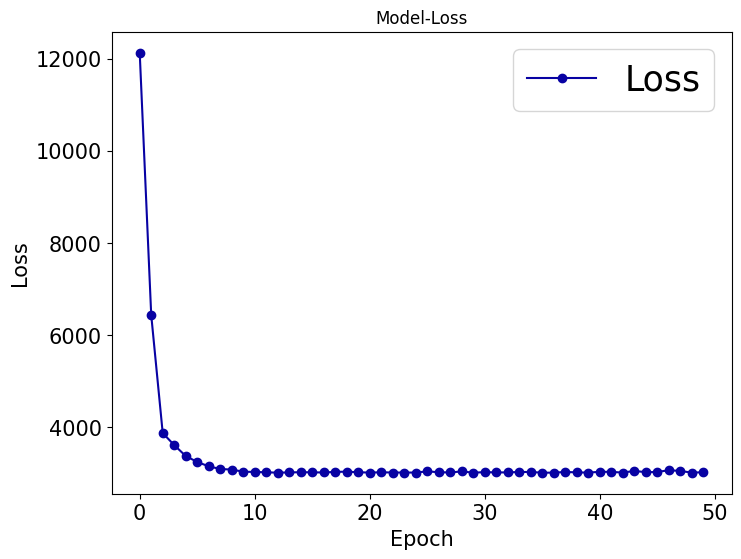

In [15]:
# lowest loss 2195 19 epoch e
saveLossDiagram(num_epochs,losses,result_dir)

In [16]:
# Specify the path to the saved model checkpoint
model_checkpoint_path = os.path.join(result_dir,'student.pth')
# Load the saved model state_dict
model.load_state_dict(torch.load(model_checkpoint_path))

<All keys matched successfully>

Load model and get results

validation

In [17]:

outputss = []
targetss = []

# choose loss to evaluate with 
if loss == 0:
    criterion = nn.MSELoss()
else:
    def RMSELoss(yhat,y):
        return torch.sqrt(torch.mean((yhat-y)**2))
    criterion = RMSELoss

# Evaluate the model on the validation data
with torch.no_grad():
    total_loss = 0
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        outputss.append(outputs[:,0].tolist())
        targetss.append(targets.tolist())
        loss = criterion(outputs[:,0], targets.float())
        total_loss += loss.item()
    mean_loss = total_loss / len(val_loader)
    if loss == 0:
        print("Batch Size %d , Epochs %d , Learning Rate %f , Loss %f"%(batch_size, num_epochs, lr, lowest_loss))
        print(f'MSE Loss: {mean_loss:.4f}')
        SaveResults(result_dir, batch_size, num_epochs, lr, mean_loss, lowest_loss)
    else:
        print("Batch Size %d , Epochs %d , Learning Rate %f , Loss %f"%(batch_size, num_epochs, lr, lowest_loss))
        print(f'MSE Loss: {mean_loss:.4f}')
        SaveResults(result_dir, batch_size, num_epochs, lr,lowest_loss, mean_loss)

Batch Size 50 , Epochs 50 , Learning Rate 0.010000 , Loss 3015.634141
MSE Loss: 54.1089
result/student/results.csv


Flatten the data

In [18]:
outputs = []
for i in outputss:
    for j in i:
        outputs.append(j)

targets = []
for i in targetss:
    for j in i:
        targets.append(j)

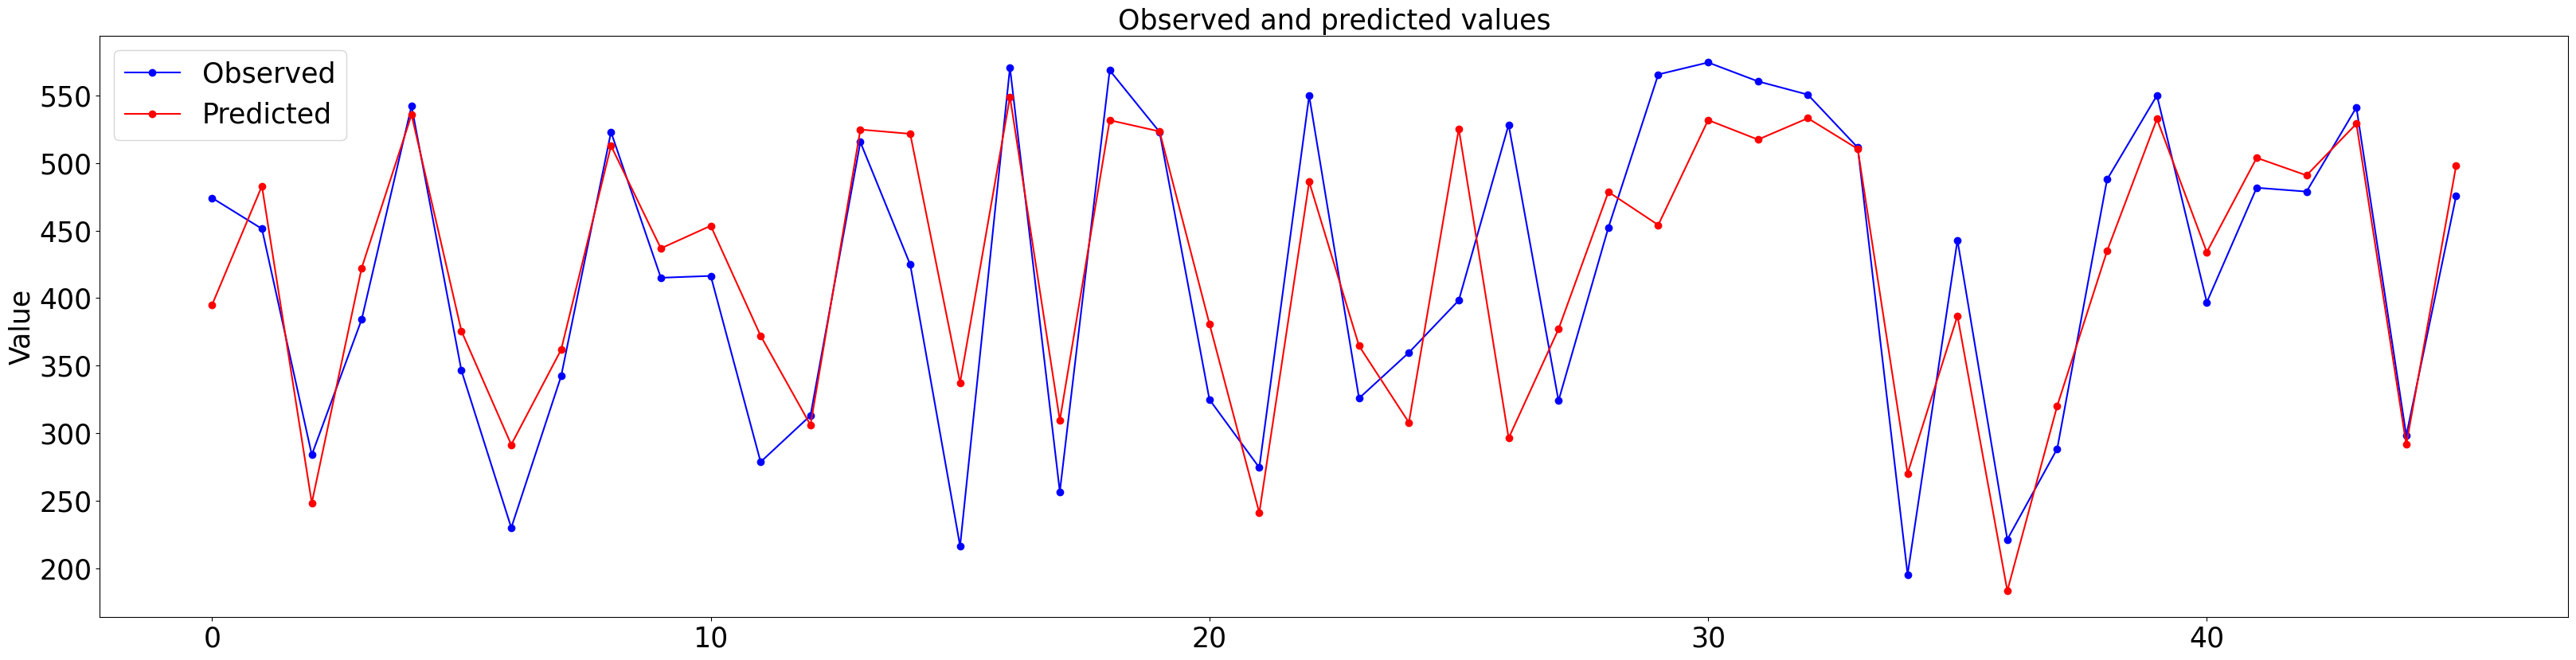

In [19]:
observedvsPredicted(result_dir, targets, outputs)

Train and Shut Down

In [20]:
# import os
# os.system("shutdown /s /t 1")